# 1. bs/m = 100/400

/tmp/ipykernel_1775134/3437326236.py:134: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(index[:len(speedups)], speedups, linestyles[i], color=colors[i],
/tmp/ipykernel_1775134/3437326236.py:134: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(index[:len(speedups)], speedups, linestyles[i], color=colors[i],
/tmp/ipykernel_1775134/3437326236.py:134: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(index[:len(speedups)], speedups, linestyles[i], color=colors[i],


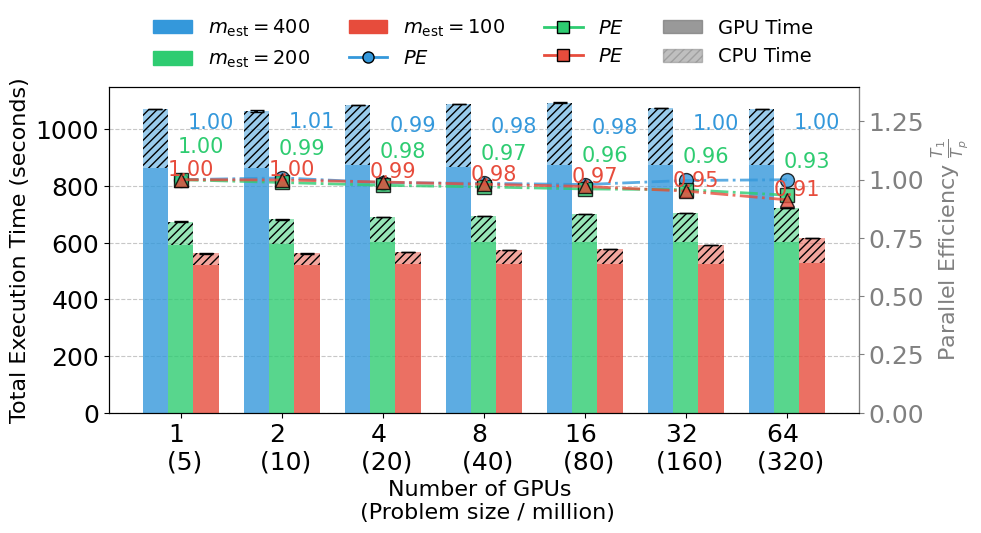

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 18})

# Define the number of processes
# n_values = [1, 2, 4, 8, 16, 32, 64]
n_values = [1, 2, 4, 8, 16, 32, 64]
n_problemsize_400 = [5 * 1e6 * n_ for n_ in n_values]

# Data structure for strong scaling with CPU and GPU time components
data = {
    'n': [],
    'cpu_time': [],
    'gpu_time': [],
    'measurement': []
}

# Generate data for two different measurements
measurements = [r'$m_{\text{est}}=400$', r'$m_{\text{est}}=200$', r'$m_{\text{est}}=100$']
# colors = ['green','blue', 'orange']
colors = ['#3498db', '#2ecc71', '#e74c3c']


# Generate data for CPU and GPU time components
for index, n in enumerate(n_values):
    # Add multiple results for each n and measurement
    for seed_ in range(1, 4):  # Three results per n value
        tag_name = n if n > 1 else "base"
        
        # First measurement
        filename0 = f'../../log/GH200_scaling/logFile_numPointsTotal{int(n_problemsize_400[index])}_numBlocksTotal{int(n_problemsize_400[index]/100)}_m{400}_seed{seed_}_isScaled1_GH200_scaling_{tag_name}.csv'     
        filename1 = f'../../log/GH200_scaling/logFile_numPointsTotal{int(n_problemsize_400[index])}_numBlocksTotal{int(n_problemsize_400[index]/100)}_m{200}_seed{seed_}_isScaled1_GH200_scaling_{tag_name}.csv'
        filename2 = f'../../log/GH200_scaling/logFile_numPointsTotal{int(n_problemsize_400[index])}_numBlocksTotal{int(n_problemsize_400[index]/100)}_m{100}_seed{seed_}_isScaled1_GH200_scaling_{tag_name}.csv'

        try:
            df0 = pd.read_csv(filename0)
            gpu_time_0 = df0['computation'].values[0] + df0['gpu_copy'].values[0] + df0['cleanup_gpu'].values[0]
            data['n'].append(n)
            data['gpu_time'].append(gpu_time_0)
            data['cpu_time'].append(df0['total'].values[0] - gpu_time_0)
            data['measurement'].append(measurements[0])
        except FileNotFoundError:
            print(f"File not found: {filename0}")
            continue
        
        try:
            df1 = pd.read_csv(filename1)
            gpu_time_1 = df1['computation'].values[0] + df1['gpu_copy'].values[0] + df1['cleanup_gpu'].values[0]
            data['n'].append(n)
            data['gpu_time'].append(gpu_time_1)
            data['cpu_time'].append(df1['total'].values[0] - gpu_time_1)
            data['measurement'].append(measurements[1])
        except FileNotFoundError:
            print(f"File not found: {filename1}")
            continue
        
        try:
            df2 = pd.read_csv(filename2)
            gpu_time_2 = df2['computation'].values[0] + df2['gpu_copy'].values[0] + df2['cleanup_gpu'].values[0]
            data['n'].append(n)
            data['gpu_time'].append(gpu_time_2)
            data['cpu_time'].append(df2['total'].values[0] - gpu_time_2)
            data['measurement'].append(measurements[2])
        except FileNotFoundError:
            print(f"File not found: {filename2}")
            continue

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate total time
df['total_time'] = df['cpu_time'] + df['gpu_time']

# Calculate mean and standard error for each group
grouped = df.groupby(['n', 'measurement']).agg({
    'cpu_time': ['mean', 'sem'],
    'gpu_time': ['mean', 'sem'],
    'total_time': ['mean', 'sem']
}).reset_index()

# Restructure the multi-level columns
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]

# Set up the plot
fig, ax1 = plt.subplots(figsize=(10, 5))  # Slightly wider to accommodate second y-axis
ax2 = ax1.twinx()  # Create a second y-axis

# Bar width and positions
bar_width = 0.25
index = np.arange(len(n_values))
index_GPUs_ps = ['1 \n (5)', '2 \n (10)', '4 \n (20)', '8 \n (40)', '16 \n (80)', '32 \n (160)', '64 \n (320)']

# Plot stacked bars for each implementation on the first y-axis
for i, measurement in enumerate(measurements):
    subset = grouped[grouped['measurement'] == measurement]
    
    gpu_means = subset['gpu_time_mean'].values
    cpu_means = subset['cpu_time_mean'].values
    total_errors = subset['total_time_sem'].values
    
    positions = index + (i - 1) * bar_width
    
    # Plot GPU time as bottom part of the stack
    gpu_bars = ax1.bar(positions[:len(gpu_means)], gpu_means, bar_width,
                       color=colors[i], 
                       alpha=0.8,
                       label=f"{measurement} (GPU)")
    
    # Plot CPU time as top part of the stack
    cpu_bars = ax1.bar(positions[:len(gpu_means)], cpu_means, bar_width,
                       bottom=gpu_means,
                       color=colors[i], 
                       alpha=0.5,
                       hatch='////',
                       label=f"{measurement} (CPU)")
    
    # Add error bars to the total height
    total_heights = gpu_means + cpu_means
    ax1.errorbar(positions[:len(total_heights)], total_heights, yerr=total_errors, 
                 fmt='none', ecolor='black', capsize=5)

# Calculate speedup for each measurement and plot on the second y-axis
linestyles = ['o-', 's-', '^-']  # Different line styles for each measurement
for i, measurement in enumerate(measurements):
    subset = grouped[grouped['measurement'] == measurement]
    # print(subset['n'])
    baseline = subset[subset['n'] == 1]['total_time_mean'].values[0]  # Time with 1 GPU
    means = subset['total_time_mean'].values
    # speedups = baseline / (means * n_values[:len(means)])  # parallel efficiency = T1/(p*Tp) * 100
    speedups = baseline / (means)  # parallel efficiency = T1/(p*Tp) * 100
    # print(speedups)
    ax2.plot(index[:len(speedups)], speedups, linestyles[i], color=colors[i], 
             linewidth=2, markersize=10, markeredgecolor='black', linestyle='-.',
             alpha=0.8,
             label=f"{measurement} Speedup")
# Add text annotations for each point
for i, measurement in enumerate(measurements):
    subset = grouped[grouped['measurement'] == measurement]
    baseline = subset[subset['n'] == 1]['total_time_mean'].values[0]
    means = subset['total_time_mean'].values
    speedups = baseline / means
    
    for j, speedup in enumerate(speedups):
        # Position text slightly above the point
        ax2.text(index[j] + 0.3 - 0.1 * i, speedup + 0.2 - 0.1 * i, f'{speedup:.2f}', 
                horizontalalignment='center',
                verticalalignment='bottom',
                fontsize=15,
                color=colors[i])

# Customize the first y-axis (execution time)
ax1.set_xlabel('Number of GPUs \n (Problem size / million)', fontsize=16)
ax1.set_ylabel('Total Execution Time (seconds)', fontsize=16)
ax1.set_xticks(index)
ax1.set_xticklabels(index_GPUs_ps)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_axisbelow(True)

# Customize the second y-axis (speedup)
ax2.set_ylabel(r'Parallel Efficiency $\frac{T_1}{T_p}$', fontsize=16)
# ax2.set_ylabel(r'Parallel Efficiency $\frac{T_1}{T_p} \times p$', fontsize=16)
ax2.spines['right'].set_color('gray')
# ax2.set_yscale('log', base=2)
ax2.set_ylim(0., 1.4)
ax2.tick_params(axis='y', colors='gray')
ax2.yaxis.label.set_color('gray')

# Create custom legend elements that better represent the stacked bars
legend_elements = []

# Add CPU+GPU combined legend items
for i, measurement in enumerate(measurements):
    # Create patch for the stacked bar representation
    legend_elements.append(plt.Rectangle((0,0), 1, 1, color=colors[i], label=measurement))

# Add speedup lines to legend
for i, measurement in enumerate(measurements):
    legend_elements.append(plt.Line2D([0], [0], marker='o' if i==0 else 's', 
                          color=colors[i], markersize=8, linewidth=2,markeredgecolor='black',
                          label=rf"$PE$"))

# Add ideal speedup line to legend
# legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', 
#                        linewidth=1.5, label='Ideal Speedup'))

# Add CPU/GPU pattern legend
gpu_patch = plt.Rectangle((0,0), 1, 1, color='gray', alpha=0.8, label='GPU Time')
cpu_patch = plt.Rectangle((0,0), 1, 1, color='gray', alpha=0.5, hatch='////', label='CPU Time')
legend_elements.extend([gpu_patch, cpu_patch])

# Combine legends in a more organized way
fig.legend(handles=legend_elements,
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.10), 
           ncol=4, 
           framealpha=0.,
           fontsize=14, 
           frameon=True)

# Adjust layout to make room for the legend at the top
# plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.savefig("./fig/GH200_weak_scaling_bs100.pdf", bbox_inches='tight')
plt.show()

[1.         1.05651989 1.07707576 1.11247431 1.15077164 1.15331405
 1.11350601]
[1.         1.02192131 1.05243593 1.06290524 1.07206022 1.05394754
 1.02302437]
[1.         1.03086841 1.04403896 1.04568563 1.03839728 1.01398029
 0.97126191]


/tmp/ipykernel_1775134/199993489.py:131: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(index[:len(speedups)], speedups, linestyles[i], color=colors[i],
/tmp/ipykernel_1775134/199993489.py:131: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(index[:len(speedups)], speedups, linestyles[i], color=colors[i],
/tmp/ipykernel_1775134/199993489.py:131: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(index[:len(speedups)], speedups, linestyles[i], color=colors[i],


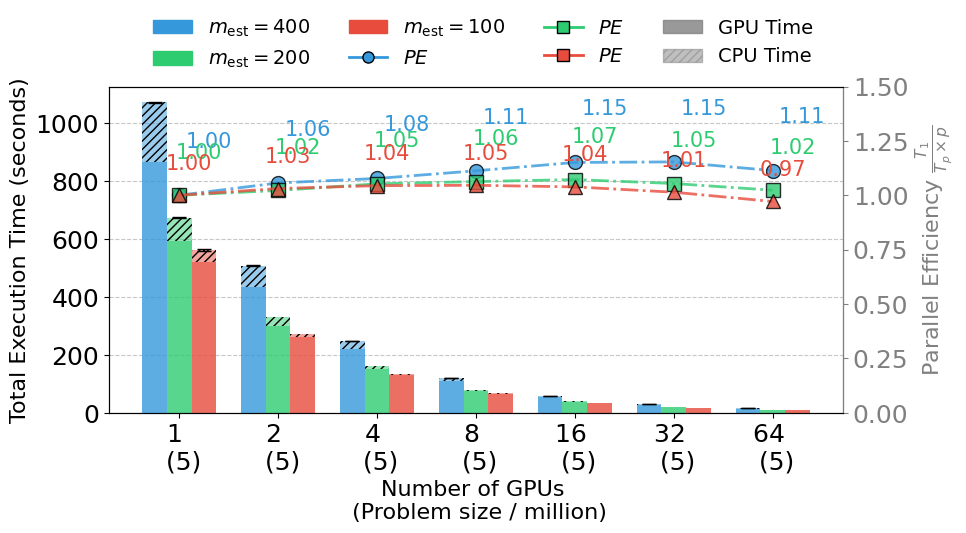

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 18})

# Define the number of processes
n_values = [1, 2, 4, 8, 16, 32, 64]
n_problemsize_400 = [5 * 1e6 for n_ in n_values]

# Data structure for strong scaling with CPU and GPU time components
data = {
    'n': [],
    'cpu_time': [],
    'gpu_time': [],
    'measurement': []
}

# Generate data for two different measurements
measurements = [r'$m_{\text{est}}=400$', r'$m_{\text{est}}=200$', r'$m_{\text{est}}=100$']
# measurements = [r'$m_{est}=200$', r'$m_{est}=400$']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Generate data for CPU and GPU time components
for index, n in enumerate(n_values):
    # Add multiple results for each n and measurement
    for seed_ in range(1, 4):  # Three results per n value
        tag_name = n if n > 1 else "base"
        
        # First measurement
        filename0 = f'../../log/GH200_scaling/logFile_numPointsTotal{int(n_problemsize_400[index])}_numBlocksTotal{int(n_problemsize_400[index]/100)}_m{400}_seed{seed_}_isScaled1_GH200_scaling_{tag_name}.csv'     
        filename1 = f'../../log/GH200_scaling/logFile_numPointsTotal{int(n_problemsize_400[index])}_numBlocksTotal{int(n_problemsize_400[index]/100)}_m{200}_seed{seed_}_isScaled1_GH200_scaling_{tag_name}.csv'
        filename2 = f'../../log/GH200_scaling/logFile_numPointsTotal{int(n_problemsize_400[index])}_numBlocksTotal{int(n_problemsize_400[index]/100)}_m{100}_seed{seed_}_isScaled1_GH200_scaling_{tag_name}.csv'
        
        try:
            df0 = pd.read_csv(filename0)
            data['n'].append(n)
            gpu_time_0 = df0['computation'].values[0] + df0['gpu_copy'].values[0] + df0['cleanup_gpu'].values[0]
            data['gpu_time'].append(gpu_time_0)
            data['cpu_time'].append(df0['total'].values[0] - gpu_time_0)
            data['measurement'].append(measurements[0])
        except FileNotFoundError:
            # print(f"File not found: {filename0}")
            continue
        
        try:
            df1 = pd.read_csv(filename1)
            gpu_time_1 = df1['computation'].values[0] + df1['gpu_copy'].values[0] + df1['cleanup_gpu'].values[0]    
            data['n'].append(n)
            data['gpu_time'].append(gpu_time_1)
            data['cpu_time'].append(df1['total'].values[0] - gpu_time_1)
            data['measurement'].append(measurements[1])
        except FileNotFoundError:
            # print(f"File not found: {filename1}")
            continue
        
        try:
            df2 = pd.read_csv(filename2)
            gpu_time_2 = df2['computation'].values[0] + df2['gpu_copy'].values[0] + df2['cleanup_gpu'].values[0]
            data['n'].append(n)
            data['gpu_time'].append(gpu_time_2)
            data['cpu_time'].append(df2['total'].values[0] - gpu_time_2)
            data['measurement'].append(measurements[2])
        except FileNotFoundError:
            # print(f"File not found: {filename2}")
            continue

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate total time
df['total_time'] = df['cpu_time'] + df['gpu_time']

# Calculate mean and standard error for each group
grouped = df.groupby(['n', 'measurement']).agg({
    'cpu_time': ['mean', 'sem'],
    'gpu_time': ['mean', 'sem'],
    'total_time': ['mean', 'sem']
}).reset_index()

# Restructure the multi-level columns
grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]

# Set up the plot
fig, ax1 = plt.subplots(figsize=(10, 5))  # Slightly wider to accommodate second y-axis
ax2 = ax1.twinx()  # Create a second y-axis

# Bar width and positions
bar_width = 0.25
index = np.arange(len(n_values))
index_GPUs_ps = ['1 \n (5)', '2 \n (5)', '4 \n (5)', '8 \n (5)', '16 \n (5)', '32 \n (5)', '64 \n (5)']

# Plot stacked bars for each implementation on the first y-axis
for i, measurement in enumerate(measurements):
    subset = grouped[grouped['measurement'] == measurement]
    
    gpu_means = subset['gpu_time_mean'].values
    cpu_means = subset['cpu_time_mean'].values
    total_errors = subset['total_time_sem'].values
    
    positions = index + (i - 1) * bar_width
    
    # Plot GPU time as bottom part of the stack
    gpu_bars = ax1.bar(positions[:len(gpu_means)], gpu_means, bar_width,
                       color=colors[i], 
                       alpha=0.8,
                       label=f"{measurement} (GPU)")
    
    # Plot CPU time as top part of the stack
    cpu_bars = ax1.bar(positions[:len(gpu_means)], cpu_means, bar_width,
                       bottom=gpu_means,
                       color=colors[i], 
                       alpha=0.5,
                       hatch='////',
                       label=f"{measurement} (CPU)")
    
    # Add error bars to the total height
    total_heights = gpu_means + cpu_means
    ax1.errorbar(positions[:len(total_heights)], total_heights, yerr=total_errors, 
                 fmt='none', ecolor='black', capsize=5)

# Calculate speedup for each measurement and plot on the second y-axis
linestyles = ['o-', 's-', '^-']  # Different line styles for each measurement
for i, measurement in enumerate(measurements):
    subset = grouped[grouped['measurement'] == measurement]
    baseline = subset[subset['n'] == 1]['total_time_mean'].values[0]  # Time with 1 GPU
    means = subset['total_time_mean'].values
    # speedups = baseline / (means * n_values[:len(means)])  # parallel efficiency = T1/(p*Tp) * 100
    speedups = baseline / (means * n_values[:len(means)])  # parallel efficiency = T1/(p*Tp) * 100
    print(speedups)
    ax2.plot(index[:len(speedups)], speedups, linestyles[i], color=colors[i], 
             linewidth=2, markersize=10, markeredgecolor='black', linestyle='-.',
             alpha=0.8,
             label=f"{measurement} Speedup")
# Add text annotations for each point
for i, measurement in enumerate(measurements):
    subset = grouped[grouped['measurement'] == measurement]
    baseline = subset[subset['n'] == 1]['total_time_mean'].values[0]
    means = subset['total_time_mean'].values
    speedups = baseline / (means * n_values[:len(means)])
    
    for j, speedup in enumerate(speedups):
        # Position text slightly above the point
        ax2.text(index[j] + 0.3 - 0.1 * i, speedup +0.2 - 0.05 * i, f'{speedup:.2f}', 
                horizontalalignment='center',
                verticalalignment='bottom',
                fontsize=15,
                color=colors[i])

# Customize the first y-axis (execution time)
ax1.set_xlabel('Number of GPUs \n (Problem size / million)', fontsize=16)
ax1.set_ylabel('Total Execution Time (seconds)', fontsize=16)
ax1.set_xticks(index)
# ax1.set_ylim(0, 1400)
ax1.set_xticklabels(index_GPUs_ps)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_axisbelow(True)

# Customize the second y-axis (speedup)
ax2.set_ylabel(r'Parallel Efficiency $\frac{T_1}{T_p \times p}$', fontsize=16)
# ax2.set_ylabel(r'Parallel Efficiency $\frac{T_1}{T_p} \times p$', fontsize=16)
ax2.spines['right'].set_color('gray')
# ax2.set_yscale('log', base=2)
ax2.set_ylim(0., 1.5)
ax2.tick_params(axis='y', colors='gray')
ax2.yaxis.label.set_color('gray')

# Create custom legend elements that better represent the stacked bars
legend_elements = []

# Add CPU+GPU combined legend items
for i, measurement in enumerate(measurements):
    # Create patch for the stacked bar representation
    legend_elements.append(plt.Rectangle((0,0), 1, 1, color=colors[i], label=measurement))

# Add speedup lines to legend
for i, measurement in enumerate(measurements):
    legend_elements.append(plt.Line2D([0], [0], marker='o' if i==0 else 's', 
                          color=colors[i], markersize=8, linewidth=2,markeredgecolor='black',
                          label=rf"$PE$"))

# Add CPU/GPU pattern legend
gpu_patch = plt.Rectangle((0,0), 1, 1, color='gray', alpha=0.8, label='GPU Time')
cpu_patch = plt.Rectangle((0,0), 1, 1, color='gray', alpha=0.5, hatch='////', label='CPU Time')
legend_elements.extend([gpu_patch, cpu_patch])

# Combine legends in a more organized way
fig.legend(handles=legend_elements,
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.10), 
           ncol=4, 
           framealpha=0.,
           fontsize=14, 
           frameon=True)

# Adjust layout to make room for the legend at the top
plt.tight_layout()
plt.savefig("./fig/GH200_strong_scaling_bs100.pdf", bbox_inches='tight')
plt.show()

# Power



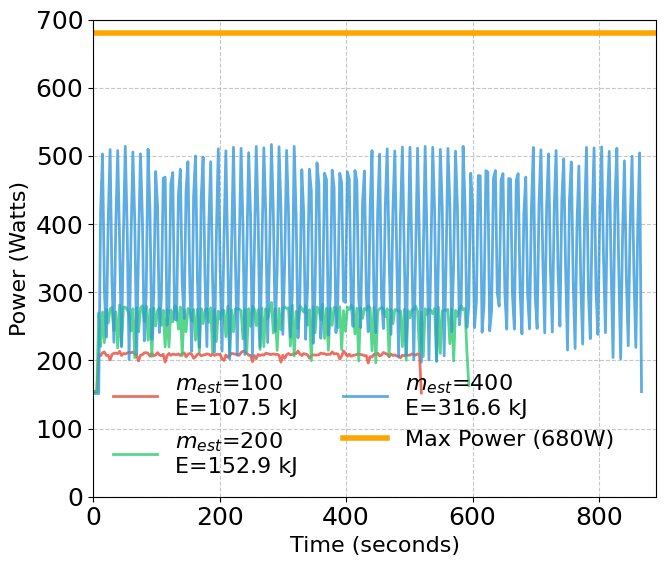

In [2]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

plt.rcParams.update({'font.size': 18})

cpu_power_cap=(100) #100 200

def process_gpu_log(file_path):
    # Read CSV with custom timestamp parsing
    df = pd.read_csv(file_path, skiprows=1)
    df.columns = ['timestamp', 'index', 'power', 'utilization', 'memory_used', 'memory_total', 'temperature']
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # print(df.head())
    # Filter for GPU 0 only
    gpu0_data = df[df['index'] == 0].copy()
    
    # Calculate time in seconds from start
    start_time = gpu0_data['timestamp'].min()
    gpu0_data['time_seconds'] = (gpu0_data['timestamp'] - start_time).dt.total_seconds()
    
    # Convert power values to float
    gpu0_data['power'] = gpu0_data['power'].str.rstrip(' W').astype(float)
    
    return gpu0_data

def plot_power_consumption(start_time=300, end_time=340):
    """
    Plot power consumption for different m values within specified time interval and calculate energy
    
    Parameters:
    start_time (float): Start time in seconds
    end_time (float): End time in seconds
    """
    
    # Create the visualization
    plt.figure(figsize=(7, 6))

    # Process and plot data for different m values
    m_values = [100, 200, 400]
    # colors = ['blue', 'orange', 'green']
    colors = ['#e74c3c', '#2ecc71', '#3498db']

    for m, color in zip(m_values, colors):
        try:
            file_path = f'../../log/GH200_power_cpu_{cpu_power_cap}/monitoring/gpu_N5000000_m{m}_i1_gpu1_power.log'
            data = process_gpu_log(file_path)
            
            # Filter for specified time interval
            mask = (data['time_seconds'] >= start_time) & (data['time_seconds'] <= end_time)
            filtered_data = data[mask]
            
            # Calculate energy (joules) using numerical integration (trapezoidal rule)
            energy = np.trapz(filtered_data['power'], filtered_data['time_seconds'])
            
            plt.plot(filtered_data['time_seconds'], 
                    filtered_data['power'],
                    label=f'$m_{{est}}$={m}\nE={energy/1000:.1f} kJ',
                    color=color,
                    linewidth=2,
                    alpha=0.8)
        except Exception as e:
            print(f"Could not process data for m={m}: {str(e)}")

    # Add horizontal line for max power
    plt.axhline(y=680, color='orange', linewidth=4, linestyle='-', label='Max Power (680W)')

    plt.xlabel('Time (seconds)', fontsize=16)
    plt.ylabel('Power (Watts)', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=16, ncol=2, framealpha=0.)

    # Set axis limits
    plt.xlim(start_time, end_time)
    plt.ylim(0, 700)  # slightly above 900 to show the line clearly

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'./fig/gpu0_power_analysis_GH200_cpu_{cpu_power_cap}_{start_time}_{end_time}.pdf', bbox_inches='tight')
    plt.show()

# Example usage:
plot_power_consumption(start_time=0, end_time=890)

In [3]:
# if you want to use jpwr to plot the power consumptionm
# pipx install git+https://github.com/FZJ-JSC/jpwr

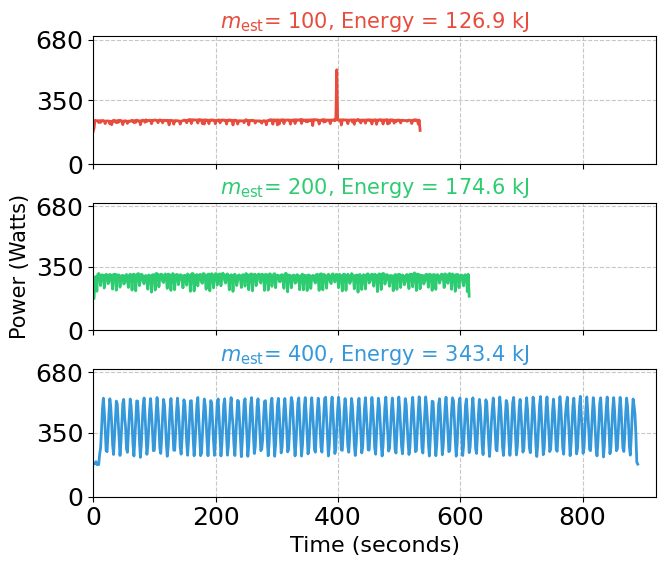

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

plt.rcParams.update({'font.size': 18})

def process_gpu_log(file_path):
    # Read CSV with custom timestamp parsing
    df = pd.read_csv(file_path)
    # print(df.head())    
    # df.columns = ['timestamp', 'index', 'power', 'utilization', 'memory_used', 'memory_total', 'temperature']
    
    # Convert timestamp to datetime
    df['timestamps'] = pd.to_datetime(df['timestamps'], unit="s")
    # print(df['timestamps'] )
    # Filter for GPU 0 only
    # gpu0_data = df[df['index'] == 0].copy()
    
    # Calculate time in seconds from start
    start_time = df['timestamps'].min()
    df['time_seconds'] = (df['timestamps'] - start_time).dt.total_seconds()
    
    # Convert power values to float
    # df['pynvml:0'] = df['pynvml:0'].str.rstrip(' W').astype(float)
    
    return df.copy()

def plot_power_consumption(start_time=300, end_time=340):
    """
    Plot power consumption for different m values within specified time interval and calculate energy
    Using three stacked subplots that share the same x-axis
    
    Parameters:
    start_time (float): Start time in seconds
    end_time (float): End time in seconds
    """
    
    # Create figure and three stacked subplots with shared x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
    axes = [ax1, ax2, ax3]
    
    # Process and plot data for different m values
    m_values = [100, 200, 400]
    # colors = ['blue', 'orange', 'green']
    colors = ['#e74c3c', '#2ecc71', '#3498db']
    
    # Store energy values for labeling
    energy_values = []
    
    for i, (m, color) in enumerate(zip(m_values, colors)):
        try:
            file_path = f'../../log/GH200_power_cpu_200_jpwr/monitoring/gpu_N5000000_m{m}_i1_gpu1_power.log'
            data = process_gpu_log(file_path)
            
            # Filter for specified time interval
            mask = (data['time_seconds'] >= start_time) & (data['time_seconds'] <= end_time)
            filtered_data = data[mask]
            
            # Calculate energy (joules) using numerical integration (trapezoidal rule)
            energy = np.trapz(filtered_data['pynvml:0'], filtered_data['time_seconds'])
            energy_values.append(energy/1000)  # convert to kJ
            
            # Plot on the appropriate subplot
            ax = axes[i]
            ax.plot(filtered_data['time_seconds'][::30], 
                   filtered_data['pynvml:0'][::30],
                   color=color,
                   linewidth=2)
            
            # Set subplot title and y-axis label
            ax.set_title(r'$m_{\text{est}}$' + f'= {m}, Energy = {energy/1000:.1f} kJ', 
                        fontsize=15, color=color)
            ax.set_ylim(0, 700)
            # Add grid
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Set y-axis limits with some padding
            min_val = max(0, filtered_data['pynvml:0'].min() - 20)  # Ensure bottom limit is not negative
            max_val = filtered_data['pynvml:0'].max() + 20
            # ax.set_ylim(min_val, max_val)
            
        except Exception as e:
            print(f"Could not process data for m={m}: {str(e)}")
    
    # Set common x-axis label (only on bottom subplot)
    ax3.set_xlabel('Time (seconds)', fontsize=16)
    
    # Set x-axis limits
    ax1.set_xlim(start_time, end_time)
    
    # # Add max power reference line to each subplot
    # for ax in axes:
    #     ax.axhline(y=680, color='orange', linewidth=2, linestyle='--', 
    #               label='680W-<measured Grace power consumption>')
        
    # Add a small legend to the bottom subplot
    # ax1.legend(loc='upper right', fontsize=14)
    ax2.set_ylabel('Power (Watts)', fontsize=15)
    # Set y-axis ticks to 250, 500, 700
    for ax in axes:
        ax.set_yticks([0, 350, 680])
    
    # Adjust layout
    plt.tight_layout()
    
    # Add a little more space between subplots
    plt.subplots_adjust(hspace=0.3)
    
    # Save the plot
    plt.savefig(f'./fig/gpu0_power_analysis_GH200_{start_time}_{end_time}_stacked.pdf', bbox_inches='tight')
    plt.show()
# Example usage:
plot_power_consumption(start_time=0, end_time=920)